In [1]:
import numpy as np 
import pandas as pd 

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

PATH = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


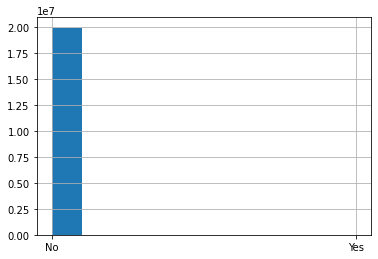

In [3]:
df = pd.read_csv(PATH / "credit_card_transactions-ibm_v2.csv", nrows=20000000)
df['Is Fraud?'].hist()

Попробуем забалансить количество "Yes"

In [4]:
print(len(df[df["Is Fraud?"] == "Yes"]) / len(df))

0.0012297


## Downsampling

Т.к. данных слишком мало будет удалять *негативы*, что бы выбить хотя бы 1% для *позитивов*

Удалим 75% всех "No"

In [5]:
def downsampling(df):
    yes_df = df[df["Is Fraud?"] == "Yes"]
    no_df = df[df["Is Fraud?"] == "No"]
    no_df = no_df.sample(frac=0.25)
    return pd.concat([yes_df, no_df]).sort_values("User")

df = downsampling(df)

In [6]:
print(len(df[df["Is Fraud?"] == "Yes"]) / len(df))
print(f"Total {len(df)}")

0.0049007202628064545
Total 5018446


In [7]:
def dollars_to_double(df, column_names):
    for column_name in column_names: 
        df[column_name] = df[column_name].apply(lambda x: x[1:])
        df[column_name] = pd.to_numeric(df[column_name])
    return df

def to_numeric(df, column_names):
    for column_name in column_names: 
        df[column_name] = pd.to_numeric(df[column_name])
    return df

def time_split(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
    return df

In [8]:
df = df.drop(['Merchant Name', 'Merchant Name'], axis=1)
df = to_numeric(df, ['Year', 'Month', 'Day', 'Zip', 'MCC'])
df = dollars_to_double(df, ['Amount'])
df = time_split(df, 'Time')
df.head()

User  Card  Year  Month  ...      Zip   MCC  Errors? Is Fraud?
4099      0     0  2015     11  ...      NaN  3001      NaN       Yes
14446     0     3  2010      3  ...  91752.0  5541      NaN        No
15140     0     3  2011      7  ...  91754.0  5411      NaN        No
3839      0     0  2014      9  ...  91750.0  5300      NaN        No
9707      0     2  2015     11  ...  91750.0  5912      NaN        No

[5 rows x 14 columns]

In [9]:
train_df=df.sample(frac=0.8,random_state=200)
test_df=df.drop(train_df.index)

In [10]:
!pip install catboost
!pip install shap

In [11]:
from catboost import CatBoostClassifier, Pool

train_y = train_df["Is Fraud?"].apply(lambda x: 1 if x == "Yes" else 0).tolist()
train_X = train_df[['Year', 'Month', 'Day', 
        'Amount', 'Use Chip', 
        'Merchant State', 'Zip', 
        'MCC', 'Time'
       ]].fillna(0)

test_y = test_df["Is Fraud?"].apply(lambda x: 1 if x == "Yes" else 0).tolist()
test_X = test_df[['Year', 'Month', 'Day', 
        'Amount', 'Use Chip', 
        'Merchant State', 'Zip', 
        'MCC', 'Time'
       ]].fillna(0)

cat_features = ['Use Chip', 'Merchant State', 'MCC']

cb_model = CatBoostClassifier(iterations=150, eval_metric='AUC')
eval_dataset = Pool(test_X, test_y, cat_features)
cb_model.fit(train_X, y=train_y, cat_features=cat_features, eval_set=eval_dataset)

Learning rate set to 0.5
0:	test: 0.7480199	best: 0.7480199 (0)	total: 1.87s	remaining: 4m 39s
1:	test: 0.8744481	best: 0.8744481 (1)	total: 3.31s	remaining: 4m 5s
2:	test: 0.8983691	best: 0.8983691 (2)	total: 4.79s	remaining: 3m 54s
3:	test: 0.9029779	best: 0.9029779 (3)	total: 6.49s	remaining: 3m 56s
4:	test: 0.9171950	best: 0.9171950 (4)	total: 8.11s	remaining: 3m 55s
5:	test: 0.9245104	best: 0.9245104 (5)	total: 9.51s	remaining: 3m 48s
6:	test: 0.9326970	best: 0.9326970 (6)	total: 11s	remaining: 3m 44s
7:	test: 0.9363287	best: 0.9363287 (7)	total: 12.5s	remaining: 3m 41s
8:	test: 0.9388485	best: 0.9388485 (8)	total: 13.9s	remaining: 3m 37s
9:	test: 0.9450997	best: 0.9450997 (9)	total: 15.2s	remaining: 3m 33s
10:	test: 0.9517853	best: 0.9517853 (10)	total: 16.6s	remaining: 3m 29s
11:	test: 0.9553275	best: 0.9553275 (11)	total: 18s	remaining: 3m 26s
12:	test: 0.9555109	best: 0.9555109 (12)	total: 19.3s	remaining: 3m 23s
13:	test: 0.9567270	best: 0.9567270 (13)	total: 20.7s	remaining:

In [12]:
print(cb_model.get_best_iteration())

51


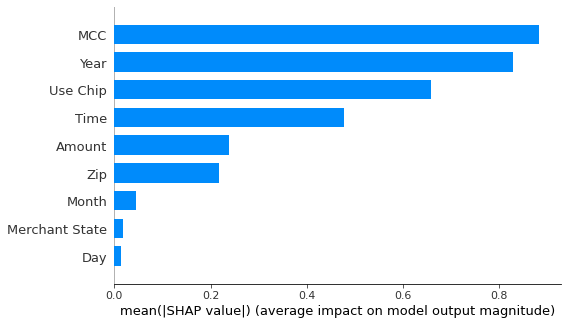

In [13]:
import shap
shap.initjs()

test_X_sample = test_X.sample(n=1000)

explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(test_X_sample)
shap.summary_plot(shap_values, test_X_sample, plot_type="bar")

In [14]:
shap.force_plot(explainer.expected_value, shap_values, test_X_sample)

Если рассмотреть график (f(x), Amount), то видно что при ~600 долларах самое высокое shap value - значит, что в этой окрестности модель более склона предсказать фрод

При рассмотрении графика (Use Chip effects, Sample orded by similatity) видно, что высокий shap value при некотром подножестве Online Transaction.

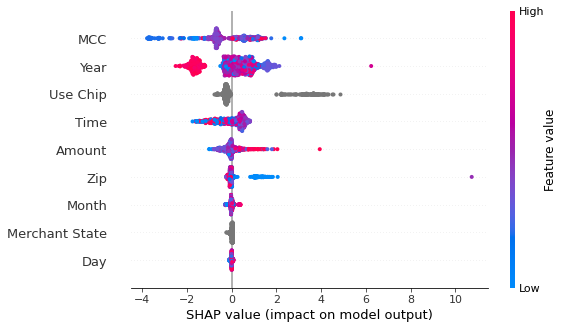

In [15]:
shap.summary_plot(shap_values, test_X_sample)

In [16]:
del cb_model
del train_df
del test_df
del test_X
del test_y
del train_X
del train_y

In [17]:
df_users = pd.read_csv(PATH / 'sd254_users.csv')
df_users = to_numeric(df_users, [
    'Current Age', 
    'Retirement Age', 
    'Birth Year', 
    'Birth Month', 
    'Latitude', 
    'Longitude',
    'FICO Score',  
    'Num Credit Cards'
    ])
df_users = dollars_to_double(df_users, ['Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt'])
df_users = df_users.drop(['Person', 'Address', 'City', 'Zipcode'], axis=1)
print(df_users.head())
df_users.index.name = 'user_id'
df = pd.merge(df, df_users, left_on='User', right_on='user_id')
del df_users

   Current Age  Retirement Age  ...  FICO Score  Num Credit Cards
0           53              66  ...         787                 5
1           53              68  ...         701                 5
2           81              67  ...         698                 5
3           63              63  ...         722                 4
4           43              70  ...         675                 1

[5 rows x 14 columns]


In [18]:
df.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?',
       'Current Age', 'Retirement Age', 'Birth Year', 'Birth Month', 'Gender',
       'Apartment', 'State', 'Latitude', 'Longitude',
       'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
       'FICO Score', 'Num Credit Cards'],
      dtype='object')

In [19]:
train_df=df.sample(frac=0.8,random_state=200)
test_df=df.drop(train_df.index)

In [20]:
from catboost import CatBoostClassifier, Pool

train_y = train_df["Is Fraud?"].apply(lambda x: 1 if x == "Yes" else 0).tolist()
train_X = train_df[['Year', 'Month', 'Day', 
        'Amount', 'Use Chip', 
        'Merchant State', 'Zip', 
        'MCC', 'Time', 'Current Age',
        'Retirement Age', 'Birth Year',
        'Birth Month', 'Gender', 'State',
        'Latitude', 'Longitude',
        'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
        'FICO Score', 'Num Credit Cards'
       ]].fillna(0)

test_y = test_df["Is Fraud?"].apply(lambda x: 1 if x == "Yes" else 0).tolist()
test_X = test_df[['Year', 'Month', 'Day', 
        'Amount', 'Use Chip', 
        'Merchant State', 'Zip', 
        'MCC', 'Time', 'Current Age',
        'Retirement Age', 'Birth Year',
        'Birth Month', 'Gender', 'State',
        'Latitude', 'Longitude',
        'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
        'FICO Score', 'Num Credit Cards'
        ]].fillna(0)

cat_features = ['Use Chip', 'Merchant State', 'MCC', 'Gender', 'State']

cb_model = CatBoostClassifier(iterations=150, eval_metric='AUC')
eval_dataset = Pool(test_X, test_y, cat_features)
cb_model.fit(train_X, y=train_y, cat_features=cat_features, eval_set=eval_dataset)

Learning rate set to 0.5
0:	test: 0.7957461	best: 0.7957461 (0)	total: 3.32s	remaining: 8m 14s
1:	test: 0.8981002	best: 0.8981002 (1)	total: 6.31s	remaining: 7m 46s
2:	test: 0.9293807	best: 0.9293807 (2)	total: 9.1s	remaining: 7m 25s
3:	test: 0.9381310	best: 0.9381310 (3)	total: 11.9s	remaining: 7m 15s
4:	test: 0.9432067	best: 0.9432067 (4)	total: 15.3s	remaining: 7m 23s
5:	test: 0.9585199	best: 0.9585199 (5)	total: 18.2s	remaining: 7m 17s
6:	test: 0.9611581	best: 0.9611581 (6)	total: 21s	remaining: 7m 8s
7:	test: 0.9633837	best: 0.9633837 (7)	total: 23.8s	remaining: 7m 2s
8:	test: 0.9640990	best: 0.9640990 (8)	total: 26.5s	remaining: 6m 55s
9:	test: 0.9654600	best: 0.9654600 (9)	total: 29.3s	remaining: 6m 50s
10:	test: 0.9664425	best: 0.9664425 (10)	total: 32.1s	remaining: 6m 46s
11:	test: 0.9666375	best: 0.9666375 (11)	total: 34.8s	remaining: 6m 40s
12:	test: 0.9669456	best: 0.9669456 (12)	total: 37.7s	remaining: 6m 37s
13:	test: 0.9701625	best: 0.9701625 (13)	total: 40.5s	remaining:

## SHAP 

Используем SHAP для интерпритации

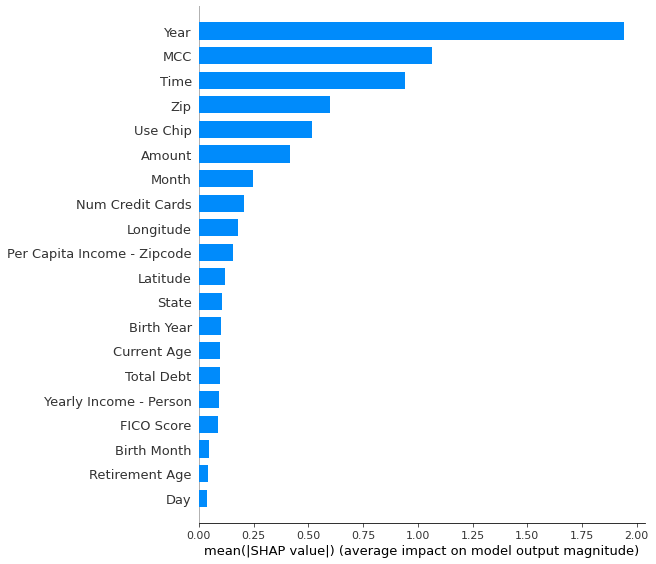

In [21]:
import shap

test_X_sample = test_X.sample(n=1000)

explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(test_X_sample)
shap.summary_plot(shap_values, test_X_sample, plot_type="bar")

In [22]:
shap.force_plot(explainer.expected_value, shap_values, test_X_sample)

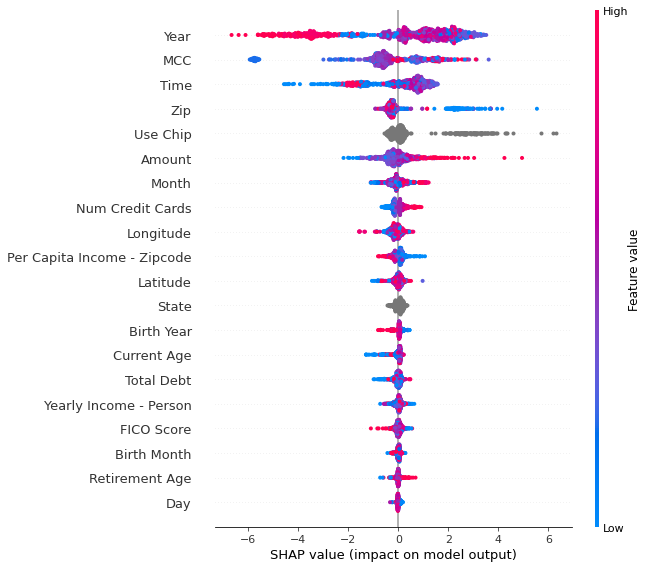

In [23]:
shap.summary_plot(shap_values, test_X_sample)

In [24]:
del cb_model
del train_df
del test_df
del test_X
del test_y
del train_X
del train_y

In [25]:
df_cards = pd.read_csv(PATH / 'sd254_cards.csv')
df_cards = dollars_to_double(df_cards, ['Credit Limit'])
df_cards = to_numeric(df_cards, ['Cards Issued', 'Year PIN last Changed', ])
df_cards = df_cards.drop(["Card Number", "CVV"], axis=1)
print(df_cards.head())
df = pd.merge(df, df_cards, left_on=["User", "Card"], right_on=["User", "CARD INDEX"])
del df_cards

   User  CARD INDEX  ... Year PIN last Changed Card on Dark Web
0     0           0  ...                  2008               No
1     0           1  ...                  2014               No
2     0           2  ...                  2004               No
3     0           3  ...                  2012               No
4     0           4  ...                  2009               No

[5 rows x 11 columns]


In [26]:
df.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?',
       'Current Age', 'Retirement Age', 'Birth Year', 'Birth Month', 'Gender',
       'Apartment', 'State', 'Latitude', 'Longitude',
       'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
       'FICO Score', 'Num Credit Cards', 'CARD INDEX', 'Card Brand',
       'Card Type', 'Expires', 'Has Chip', 'Cards Issued', 'Credit Limit',
       'Acct Open Date', 'Year PIN last Changed', 'Card on Dark Web'],
      dtype='object')

Train CatBoost

In [27]:
train_df=df.sample(frac=0.8,random_state=200)
test_df=df.drop(train_df.index)

In [28]:
from catboost import CatBoostClassifier

train_y = train_df["Is Fraud?"].apply(lambda x: 1 if x == "Yes" else 0).tolist()
train_X = train_df[['Year', 'Month', 'Day', 
        'Amount', 'Use Chip', 
        'Merchant State', 'Zip', 
        'MCC', 'Time',
        'Current Age', 
        'Retirement Age', 
        'Birth Year', 'Birth Month', 
        'Gender', 'Latitude', 'Longitude',
        'Per Capita Income - Zipcode',
        'Yearly Income - Person', 'Total Debt',
        'FICO Score', 'Num Credit Cards',
        'Card Brand', 'Card Type', 'Has Chip',
        'Cards Issued', 'Credit Limit', 
        'Year PIN last Changed', 'Card on Dark Web'
       ]].fillna(0)

test_y = test_df["Is Fraud?"].apply(lambda x: 1 if x == "Yes" else 0).tolist()
test_X = test_df[['Year', 'Month', 'Day', 
        'Amount', 'Use Chip', 
        'Merchant State', 'Zip', 
        'MCC', 'Time',
        'Current Age', 
        'Retirement Age', 
        'Birth Year', 'Birth Month', 
        'Gender', 'Latitude', 'Longitude',
        'Per Capita Income - Zipcode',
        'Yearly Income - Person', 'Total Debt',
        'FICO Score', 'Num Credit Cards',
        'Card Brand', 'Card Type', 'Has Chip',
        'Cards Issued', 'Credit Limit', 
        'Year PIN last Changed', 'Card on Dark Web'
       ]].fillna(0)

cat_features = ['Use Chip', 'Merchant State', 'Gender', 'Card Brand', 'Card Type', 'Has Chip', 'Card on Dark Web']

cb_model = CatBoostClassifier(iterations=150, eval_metric='AUC')
eval_dataset = Pool(test_X, test_y, cat_features)
cb_model.fit(train_X, y=train_y, cat_features=cat_features, eval_set=eval_dataset)

Learning rate set to 0.5
0:	test: 0.6615386	best: 0.6615386 (0)	total: 3.42s	remaining: 8m 29s
1:	test: 0.9239458	best: 0.9239458 (1)	total: 6.29s	remaining: 7m 45s
2:	test: 0.9355412	best: 0.9355412 (2)	total: 9.21s	remaining: 7m 31s
3:	test: 0.9427375	best: 0.9427375 (3)	total: 12.1s	remaining: 7m 22s
4:	test: 0.9517157	best: 0.9517157 (4)	total: 15s	remaining: 7m 15s
5:	test: 0.9562511	best: 0.9562511 (5)	total: 17.9s	remaining: 7m 10s
6:	test: 0.9562650	best: 0.9562650 (6)	total: 20.7s	remaining: 7m 2s
7:	test: 0.9570725	best: 0.9570725 (7)	total: 23.7s	remaining: 6m 59s
8:	test: 0.9586947	best: 0.9586947 (8)	total: 26.4s	remaining: 6m 53s
9:	test: 0.9641355	best: 0.9641355 (9)	total: 29.3s	remaining: 6m 49s
10:	test: 0.9656223	best: 0.9656223 (10)	total: 32.2s	remaining: 6m 46s
11:	test: 0.9669741	best: 0.9669741 (11)	total: 35.1s	remaining: 6m 43s
12:	test: 0.9674186	best: 0.9674186 (12)	total: 37.9s	remaining: 6m 39s
13:	test: 0.9685240	best: 0.9685240 (13)	total: 40.9s	remainin

## Use SHAP to explain



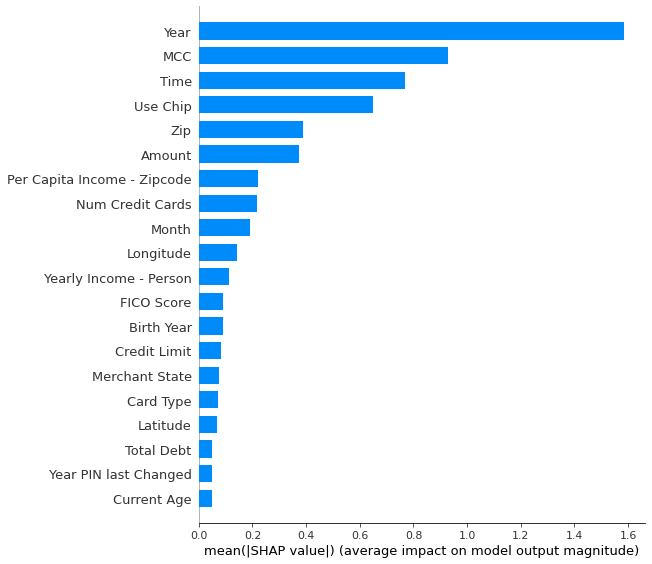

In [29]:
test_X_sample = test_X.sample(n=1000)

explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(test_X_sample)
shap.summary_plot(shap_values, test_X_sample, plot_type="bar")

In [30]:
shap.force_plot(explainer.expected_value, shap_values, test_X_sample)

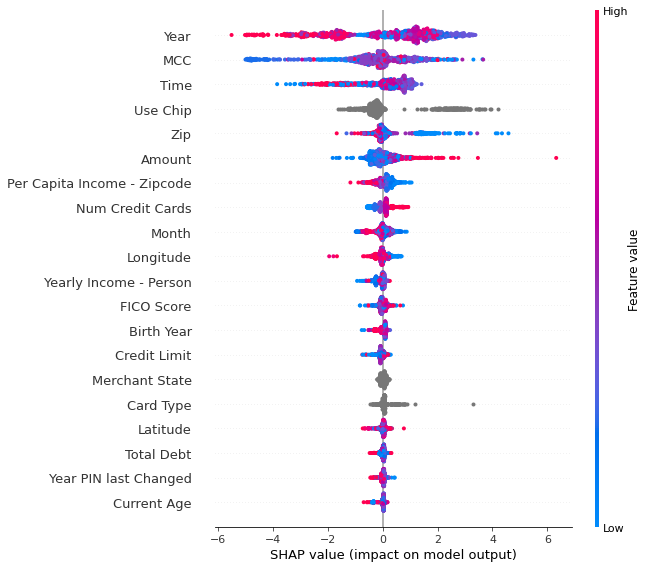

In [31]:
shap.summary_plot(shap_values, test_X_sample)